# EDA

In [1]:
import re, string, unicodedata
import nltk
import contractions
import codecs
import inflect
from nltk import word_tokenize, sent_tokenize
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import pickle

pd.set_option('display.max_rows', 5_000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_dtm = pd.read_pickle('../Datasets/Pickled_Files/DataFrame_Document_Term_Matrix.pkl')
df_dtm = df_dtm.transpose()
df_dtm.head()

Artist,Drake,Jayz,Nas,Eminem,Future,KanyeWest
02,0,0,0,1,0,0
10,0,0,1,0,0,0
100,6,2,0,0,0,0
1000,0,0,1,0,0,0
1008,0,0,0,0,1,0


## Most Common Words

In [3]:
top_dict = {}
for c in df_dtm.columns:
    top = df_dtm[c].sort_values(ascending = False).head(10)
    top_dict[c] = list(zip(top.index, top.values))
    
top_dict

{'Drake': [('know', 56),
  ('back', 54),
  ('im', 53),
  ('got', 52),
  ('like', 45),
  ('shit', 44),
  ('dont', 43),
  ('yeah', 40),
  ('one', 40),
  ('go', 40)],
 'Jayz': [('nigga', 90),
  ('im', 61),
  ('know', 51),
  ('got', 51),
  ('dont', 42),
  ('fuck', 38),
  ('one', 35),
  ('like', 30),
  ('youre', 28),
  ('aint', 28)],
 'Nas': [('one', 78),
  ('love', 76),
  ('like', 72),
  ('nas', 63),
  ('world', 62),
  ('im', 61),
  ('niggas', 41),
  ('mine', 36),
  ('represent', 34),
  ('man', 31)],
 'Eminem': [('im', 159),
  ('like', 93),
  ('get', 84),
  ('dont', 70),
  ('cause', 56),
  ('go', 45),
  ('got', 45),
  ('back', 45),
  ('fuck', 42),
  ('gonna', 39)],
 'Future': [('im', 82),
  ('fuck', 79),
  ('like', 67),
  ('yeah', 55),
  ('nigga', 49),
  ('lets', 46),
  ('niggas', 45),
  ('got', 42),
  ('future', 42),
  ('know', 42)],
 'KanyeWest': [('im', 94),
  ('like', 69),
  ('dont', 63),
  ('thats', 56),
  ('know', 53),
  ('swerve', 51),
  ('clique', 49),
  ('shit', 49),
  ('nigga', 3

In [23]:
def plot_tuples(rapper):
    rapper_df = pd.DataFrame(top_dict[rapper])
    x = 0
    y = 1
    rapper_df.sort_values(1).plot(x = x, 
                                  y = y,  
                                  kind = 'bar', 
                                  position=0.5,
                                  figsize = (20,10),
                                  grid=True,
                                  title=f"{rapper}'s Most Used Words",
                                  color = ['grey','grey','grey','grey','grey',
                                           'grey','grey','grey','grey','gold'])
    params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
    plt.style.use(params)

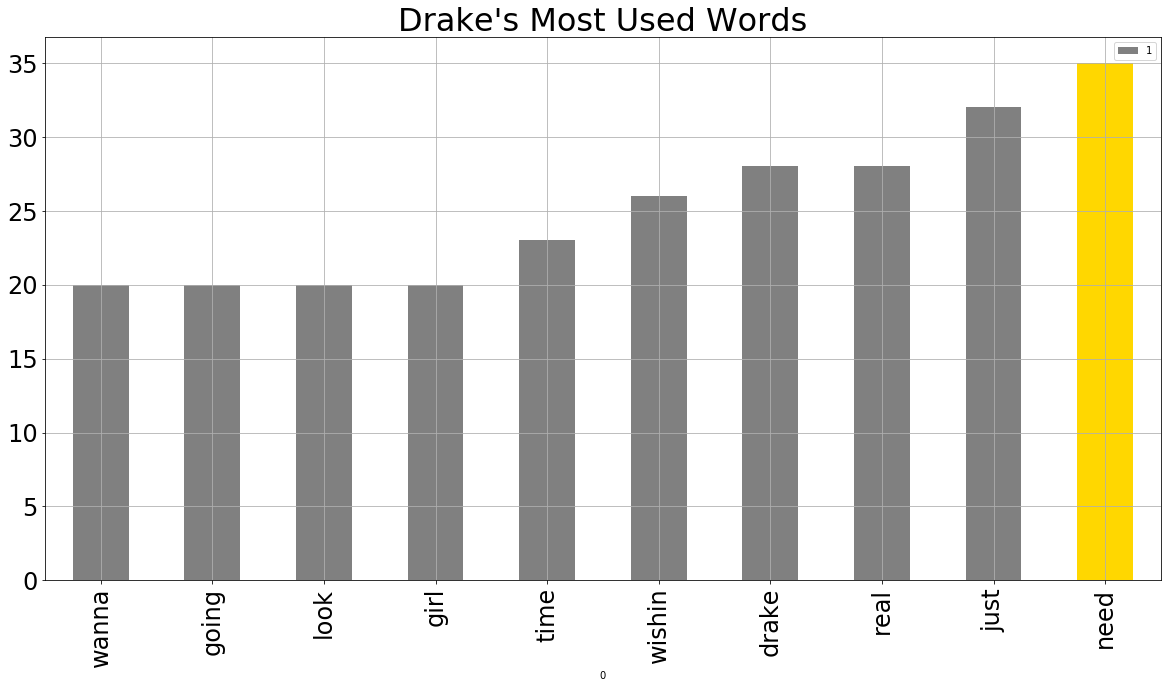

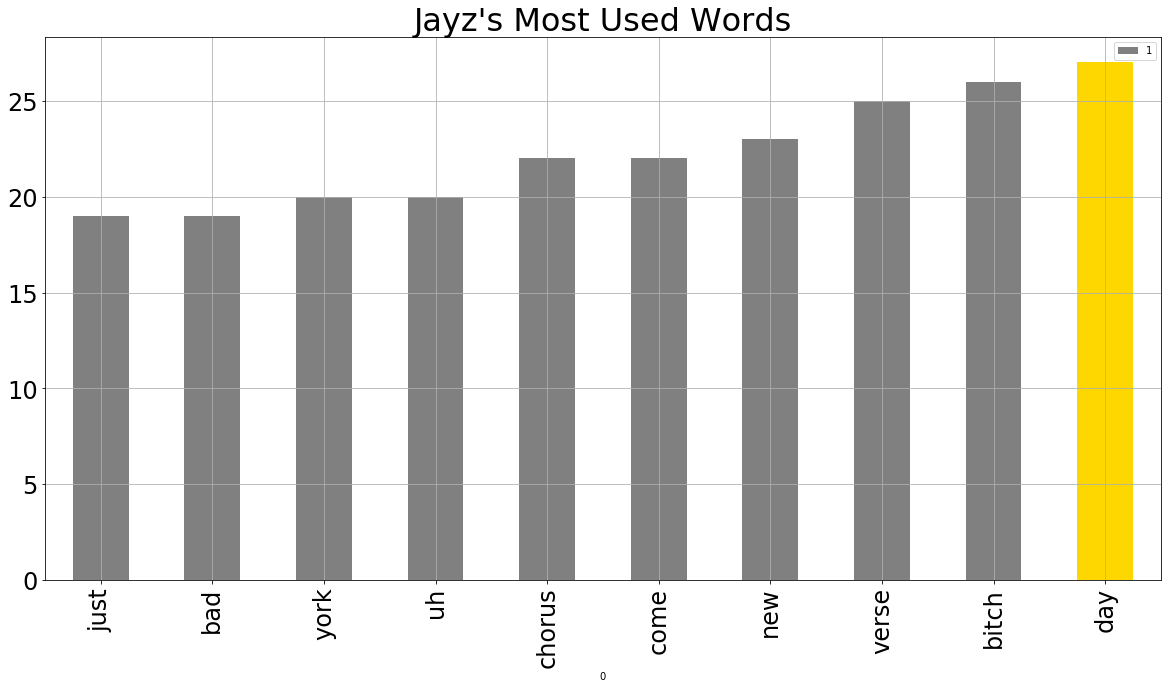

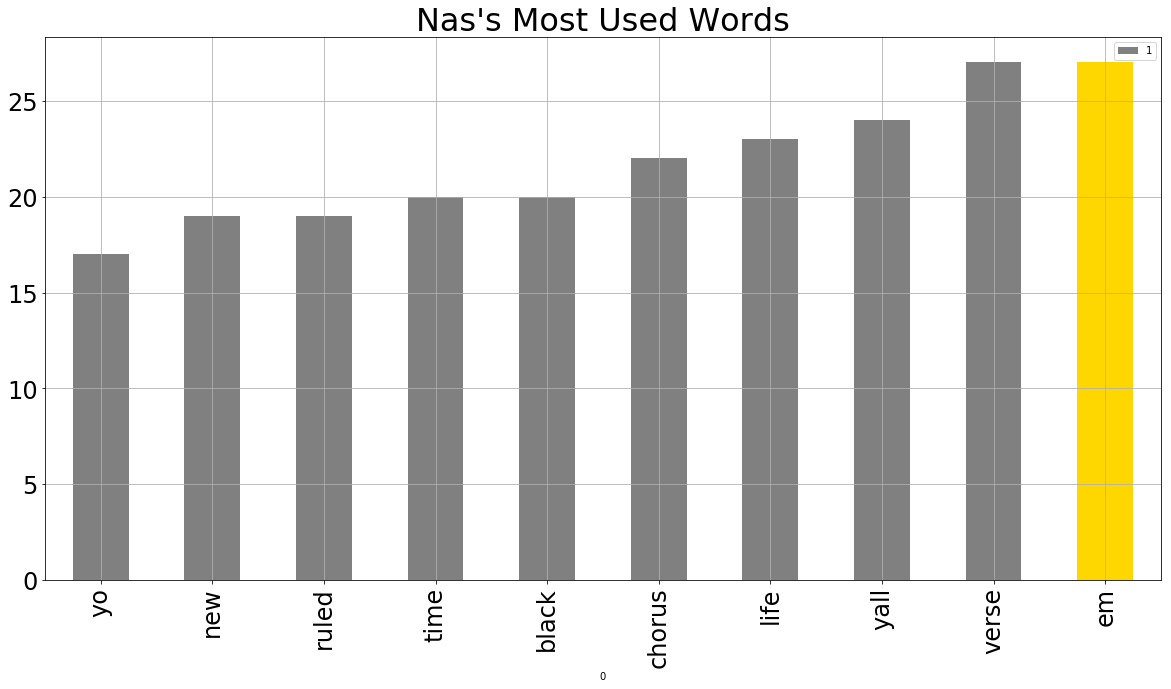

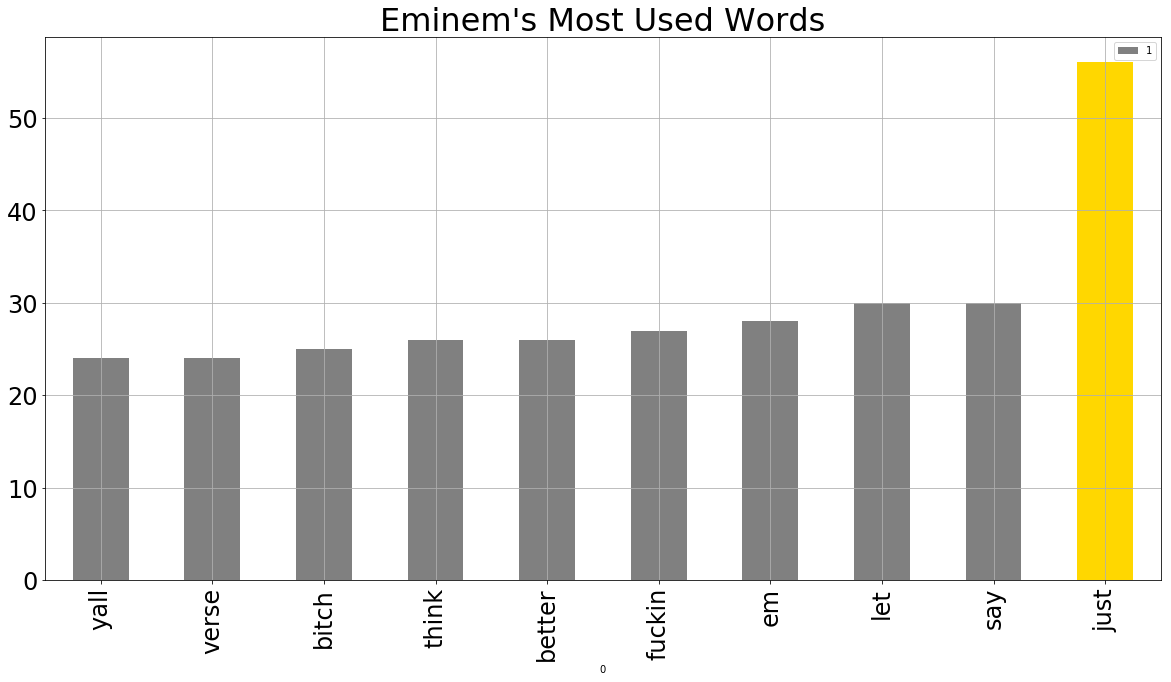

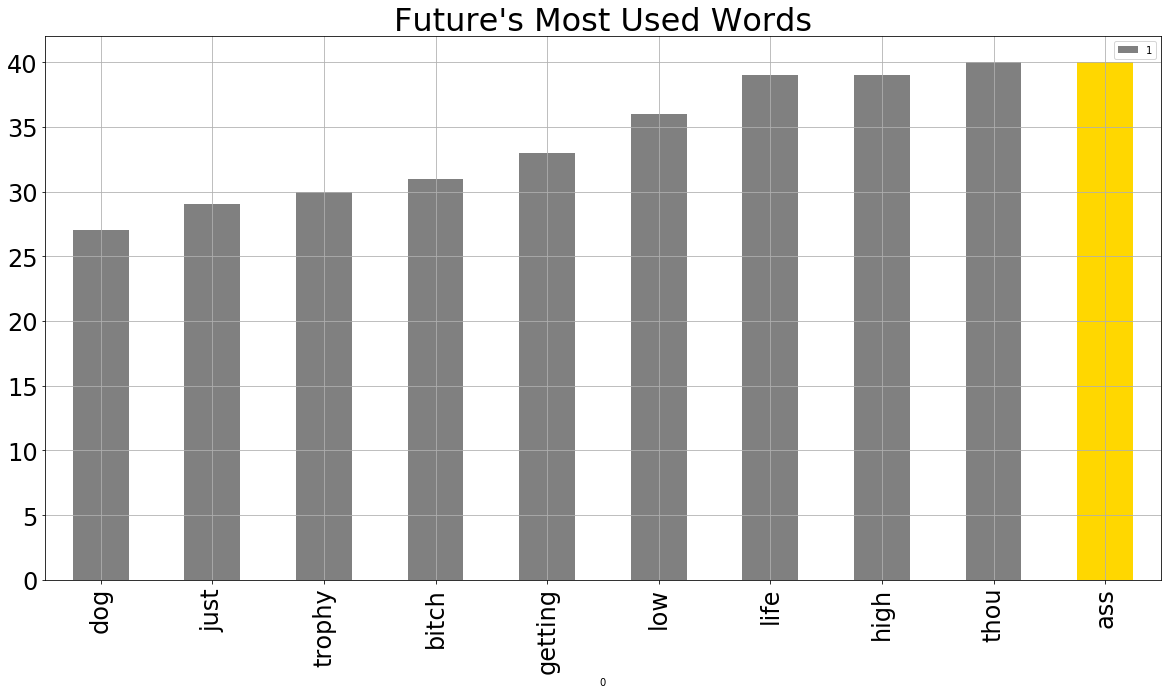

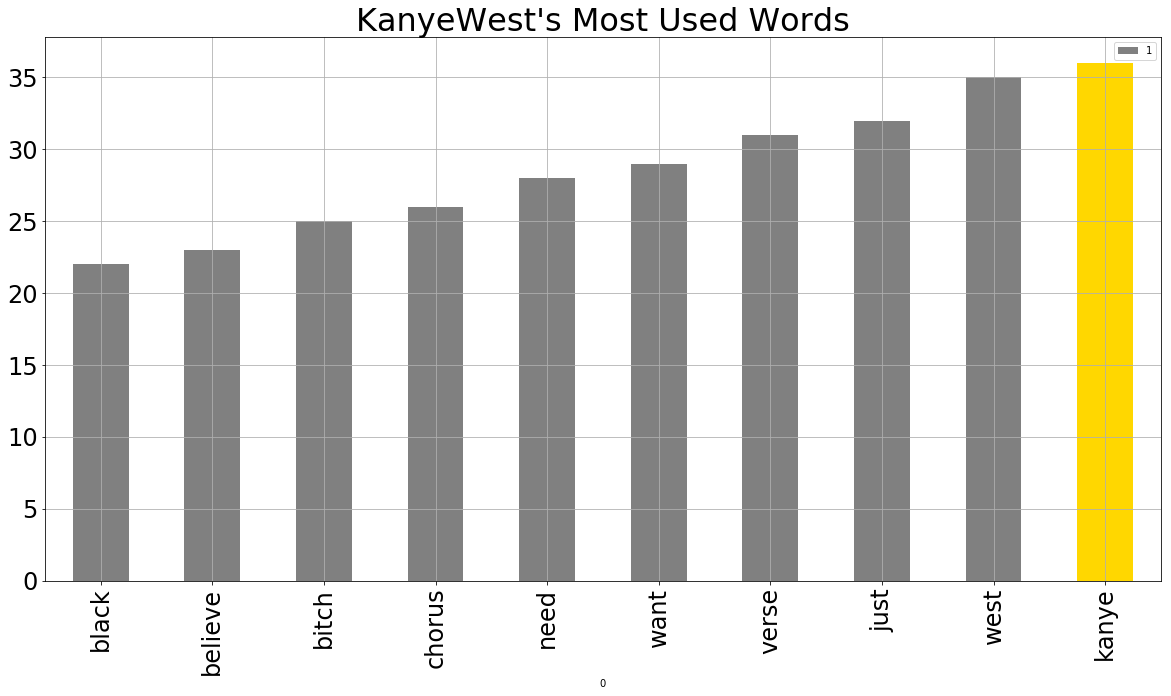

In [24]:
for rapper in df_dtm.columns:
    plot_tuples(rapper)

In [6]:
for rapper, top_words in top_dict.items():
    print(rapper)
    print(', '.join(word for word, count in top_words[0:14]))
    print('---')

Drake
know, back, im, got, like, shit, dont, yeah, one, go
---
Jayz
nigga, im, know, got, dont, fuck, one, like, youre, aint
---
Nas
one, love, like, nas, world, im, niggas, mine, represent, man
---
Eminem
im, like, get, dont, cause, go, got, back, fuck, gonna
---
Future
im, fuck, like, yeah, nigga, lets, niggas, got, future, know
---
KanyeWest
im, like, dont, thats, know, swerve, clique, shit, nigga, god
---


In [7]:
# we are going to need to add words to the stop word list since some
# words just simply shouldn't bee there. If all of the people say the
# same thing from the top list then we are going to remove them. 

from collections import Counter

words = []
for rapper in df_dtm.columns:
    top = [word for (word,count) in top_dict[rapper]]
    for t in top:
        words.append(t)

In [8]:
words[0:20]

['know',
 'back',
 'im',
 'got',
 'like',
 'shit',
 'dont',
 'yeah',
 'one',
 'go',
 'nigga',
 'im',
 'know',
 'got',
 'dont',
 'fuck',
 'one',
 'like',
 'youre',
 'aint']

In [9]:
# aggregating  this list and identifying the most common words.
Counter(words).most_common()

[('im', 6),
 ('like', 6),
 ('know', 4),
 ('got', 4),
 ('dont', 4),
 ('one', 3),
 ('nigga', 3),
 ('fuck', 3),
 ('back', 2),
 ('shit', 2),
 ('yeah', 2),
 ('go', 2),
 ('niggas', 2),
 ('youre', 1),
 ('aint', 1),
 ('love', 1),
 ('nas', 1),
 ('world', 1),
 ('mine', 1),
 ('represent', 1),
 ('man', 1),
 ('get', 1),
 ('cause', 1),
 ('gonna', 1),
 ('lets', 1),
 ('future', 1),
 ('thats', 1),
 ('swerve', 1),
 ('clique', 1),
 ('god', 1)]

In [10]:
# if more than half of the rappers have it as a top word we will exclude it
add_stop_words = [word for word, count in Counter(words).most_common()]
add_stop_words

['im',
 'like',
 'know',
 'got',
 'dont',
 'one',
 'nigga',
 'fuck',
 'back',
 'shit',
 'yeah',
 'go',
 'niggas',
 'youre',
 'aint',
 'love',
 'nas',
 'world',
 'mine',
 'represent',
 'man',
 'get',
 'cause',
 'gonna',
 'lets',
 'future',
 'thats',
 'swerve',
 'clique',
 'god']

In [11]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data

data_clean = pd.read_pickle('../Datasets/Pickled_Files/DataFrame_Corpus.pkl')

print(data_clean)

# add new stop words

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.Lyrics)
data_w_stopwords = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_w_stopwords.index = data_clean.index

data_w_stopwords.head()

                                                      Lyrics Artist Name
Artist                                                                  
Drake      produced by boi1da frank dukes noah 40 shebib ...       Drake
Jayz       intro hannah williams do i find it so hard whe...        Jayz
Nas        produced by ron browz intro fuck jay z whats u...         Nas
Eminem     verse 1 now this shits about to kick off this ...      Eminem
Future     intro high klassified な音楽 i got the truth in m...      Future
KanyeWest  produced by daft punk  kanye west verse 1 for ...   KanyeWest


,02,10,100,1000,1008,10yearolds,11,12,125,140,15,20,200,2004,2008,2015,2018,20s,20yearold,21,21st,22,247,24s,25,250,27,29,2pac,300,305,36,360,365,40,41st,45,45s,48,4main,4matic,500,50k,54,55,560,59,60,62,70,79th,80,808,80yearold,81,86,88,89,8th,91,94,96,97,99,999,9s,a1,aaaah,ability,able,abort,absurd,abundance,abused,ac,accelerants,accelerator,accent,accept,accolades,account,accounts,accuse,ace,acetaminophen,achilles,acknowledge,acres,acrobat,act,actavis,actin,acting,action,actionaction,actions,activation,active,acts,actual,actuality,actually,adats,add,adderall,addict,addicted,addiction,additional,adiós,admit,admits,admittin,adolescence,adrenaline,ads,advance,advances,advantage,advertisers,advice,aesop,affiliated,afford,afraid,africa,african,afrika,afrocentric,afterlife,aftermath,afternoon,aftershave,age,agent,ages,ago,ah,aha,ahead,ahh,aids,aight,aim,aimin,air,airplane,airplay,ak,ak47,akon,al,album,albums,alcohol,alcoholic,alert,alexander,alicia,alien,alike,alimony,alive,allan,allowed,aloof,alphabet,alright,amazin,ambien,america,ammo,amoco,amok,amped,amplified,amps,analyze,ananand,angel,angels,anger,anglosaxon,annual,ansari,answer,answers,anteater,antera,anthony,antisanta,anybody,anybodyproduced,ap,aparasite,apartheid,apartment,ape,apologize,apology,appeal,appear,apple,apply,apricot,aquamarine,arab,arca,arent,arguing,arm,armani,arms,army,aroma,arrest,arrested,arrival,arrow,arsenal,art,arthur,artillery,artist,artwork,asap,asgard,ash,ashes,ashtray,asian,ask,asked,askin,asleep,ass,assassin,asshole,assists,asstate,assumin,asteroid,ate,atlanta,attache,attack,attempt,attendance,attention,attica,...,wasted,wasting,watch,watched,watchin,watching,water,waters,wave,waves,way,wayans,wayne,ways,weak,weakness,weapon,wear,wearin,wearing,weaves,web,wed,wednesday,wee,weed,week,weekend,weeknd,weepin,weh,weighed,weighin,weighs,weight,weinstein,weird,weirder,weirdos,welcome,welfare,wellwishers,went,wept,wesley,wesson,west,westintro,weston,wet,wetter,weve,whack,whatintro,whats,whatwedodonttellyourmom,wheaties,wheel,wheels,whim,whip,whiplash,whippin,whips,whiskers,white,whitestrip,whoa,whoaohoh,whoavery,whoo,whopper,whos,whyd,wicked,wide,widild,wife,wifey,wifeys,wifin,wig,wild,wildin,wilding,william,williams,willie,willies,willing,willy,wilson,wind,winding,window,windows,wine,wining,wink,winnebago,winnie,winnin,winning,winter,winwin,wipe,wipin,wire,wisdom,wise,wish,wished,wishin,wishing,wishlist,witnessin,wives,wizkid,woadie,woah,woes,woesintro,woke,woken,wolf,woman,womanize,womans,womb,women,won,wonder,wonderful,wondering,wonders,wonka,wont,woo,wool,wop,word,words,wore,work,worked,workin,working,works,worlds,worldwide,worried,worry,worse,worshipped,worst,worth,worthless,worthy,woulda,wouldnt,wouldve,wound,wowwow,wraith,wrangler,wrath,wreak,wreck,wrench,wrist,write,writer,writers,writin,written,wrong,wrongs,wrote,wutang,wwwhen,wylin,xan,xanny,xans,ya,yachting,yachty,yacketyyack,yah,yaknowmsayin,yall,yankee,yappin,yapyap,yard,yb,ye,yeahintro,yeahproduced,yeahyeah,year,years,yee,yeezy,yell,yella,yellin,yelling,yellow,yep,yes,yesterday,yknow,yo,yodelodelayheehoo,yonder,yopper,york,youd,youintro,youll,young,younger,youngin,youngsters,youth,youthful,youuh,youve,yowe,yuh,yung,yup,yute,yuugh,zambia,zapatos,zaytoven,zazie,ze,zeros,zip,zod,zombie,zone,zonin,zöld,ölén,úgy,な音楽
Artist,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Drake,0,0,6,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,

In [12]:
# pickle these items for later
pickle.dump(cv, open('cv_stop.pkl', 'wb'))
data_w_stopwords.to_pickle('DataFrame_with_new_stopwords.pkl')

### Round 2

In [13]:
data_w_stopwords = data_w_stopwords.transpose()

top_dict = {}
for c in data_w_stopwords.columns:
    top = data_w_stopwords[c].sort_values(ascending = False).head(10)
    top_dict[c] = list(zip(top.index, top.values))
    
top_dict

{'Drake': [('need', 35),
  ('just', 32),
  ('drake', 28),
  ('real', 28),
  ('wishin', 26),
  ('time', 23),
  ('wanna', 20),
  ('going', 20),
  ('look', 20),
  ('girl', 20)],
 'Jayz': [('day', 27),
  ('bitch', 26),
  ('verse', 25),
  ('new', 23),
  ('chorus', 22),
  ('come', 22),
  ('york', 20),
  ('uh', 20),
  ('just', 19),
  ('bad', 19)],
 'Nas': [('verse', 27),
  ('em', 27),
  ('yall', 24),
  ('life', 23),
  ('chorus', 22),
  ('time', 20),
  ('black', 20),
  ('new', 19),
  ('ruled', 19),
  ('yo', 17)],
 'Eminem': [('just', 56),
  ('let', 30),
  ('say', 30),
  ('em', 28),
  ('fuckin', 27),
  ('think', 26),
  ('better', 26),
  ('bitch', 25),
  ('yall', 24),
  ('verse', 24)],
 'Future': [('thou', 40),
  ('ass', 40),
  ('life', 39),
  ('high', 39),
  ('low', 36),
  ('getting', 33),
  ('bitch', 31),
  ('trophy', 30),
  ('just', 29),
  ('dog', 27)],
 'KanyeWest': [('kanye', 36),
  ('west', 35),
  ('just', 32),
  ('verse', 31),
  ('want', 29),
  ('need', 28),
  ('chorus', 26),
  ('bitch', 

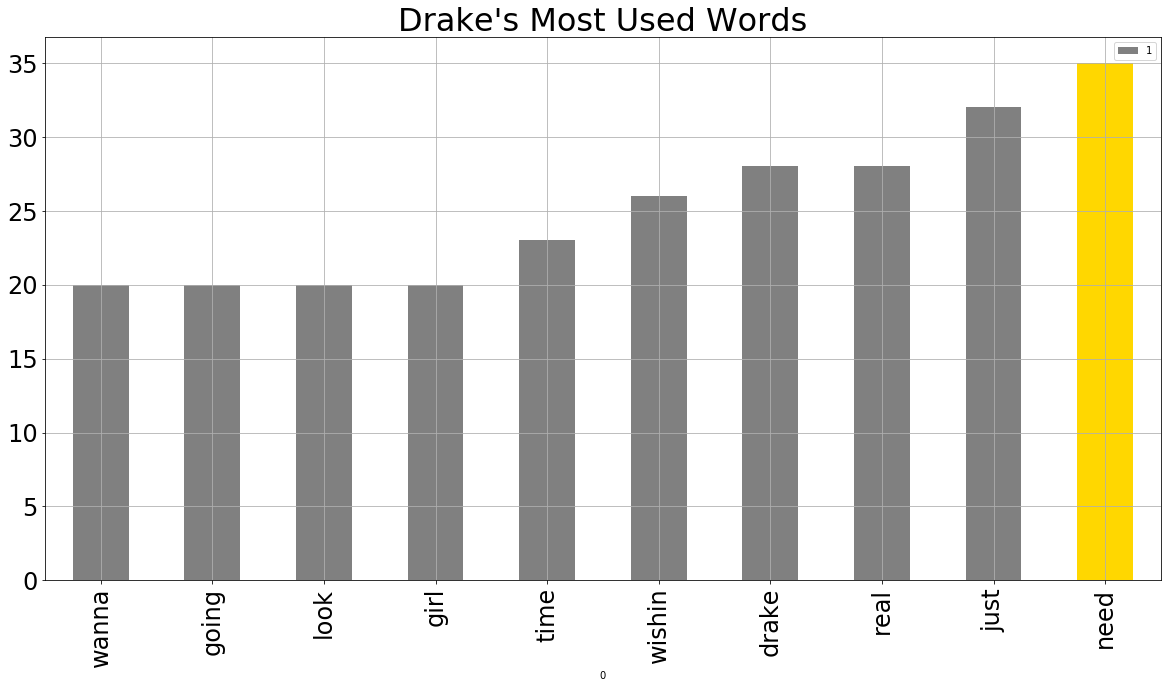

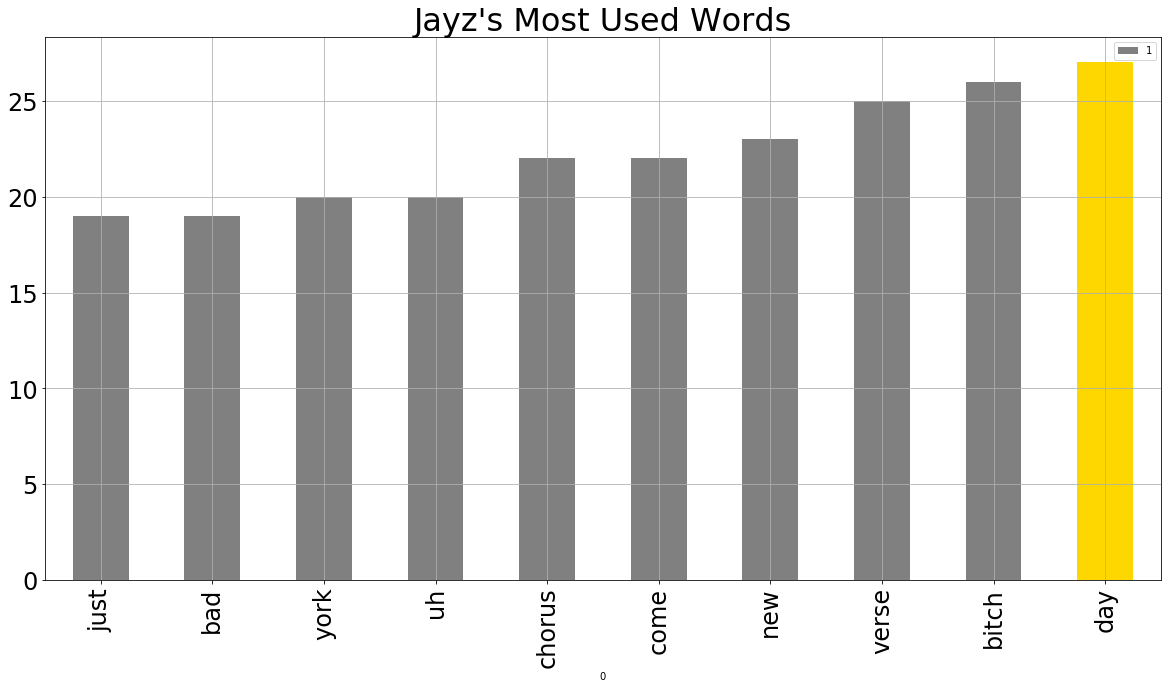

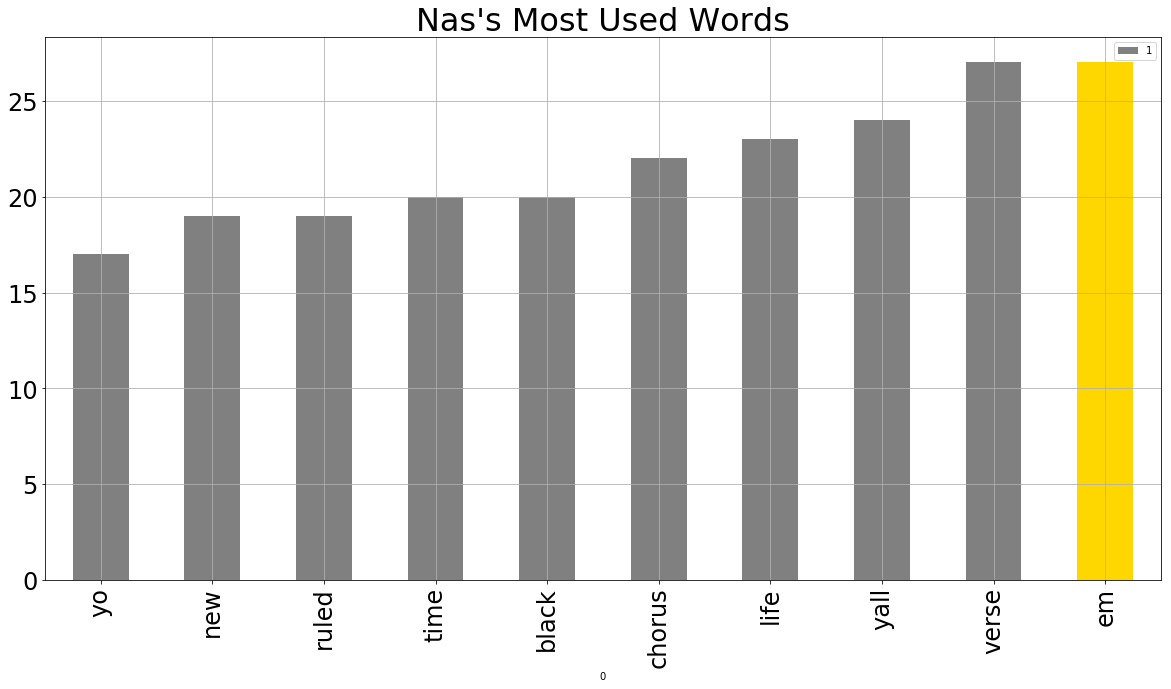

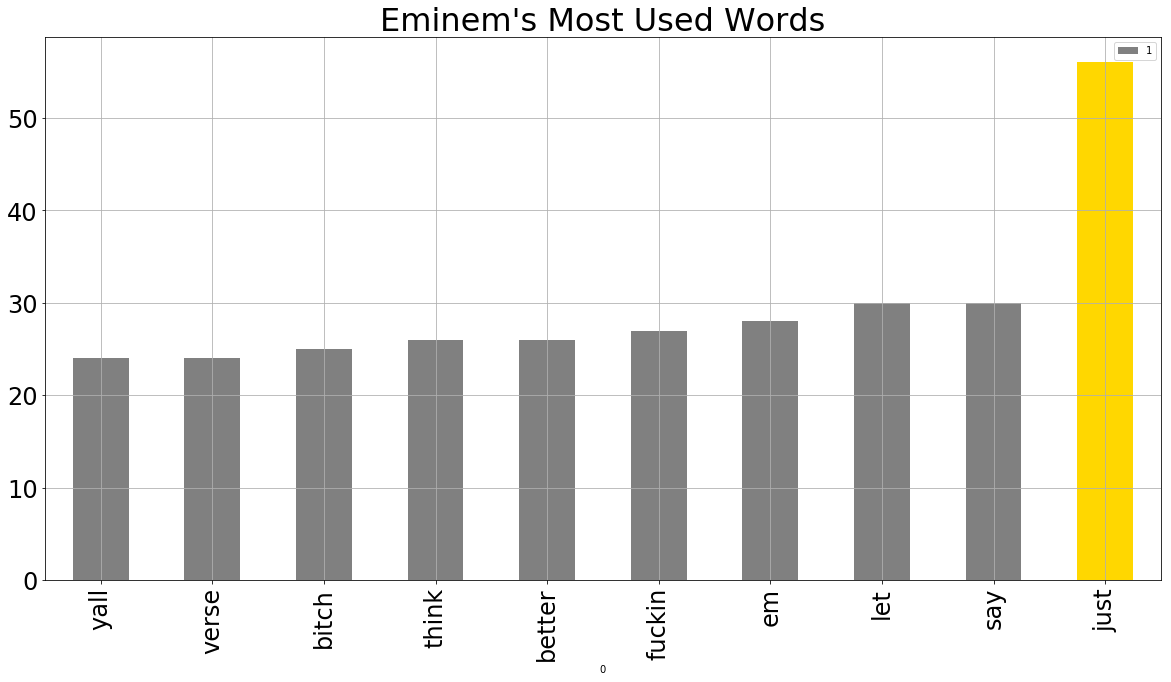

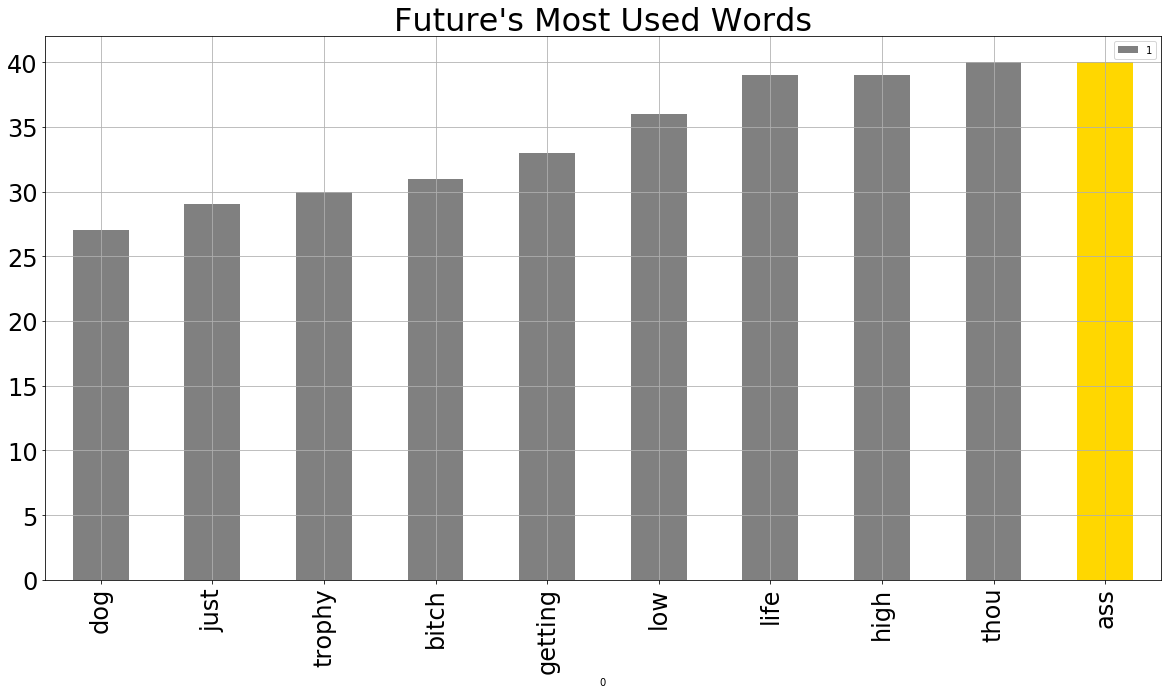

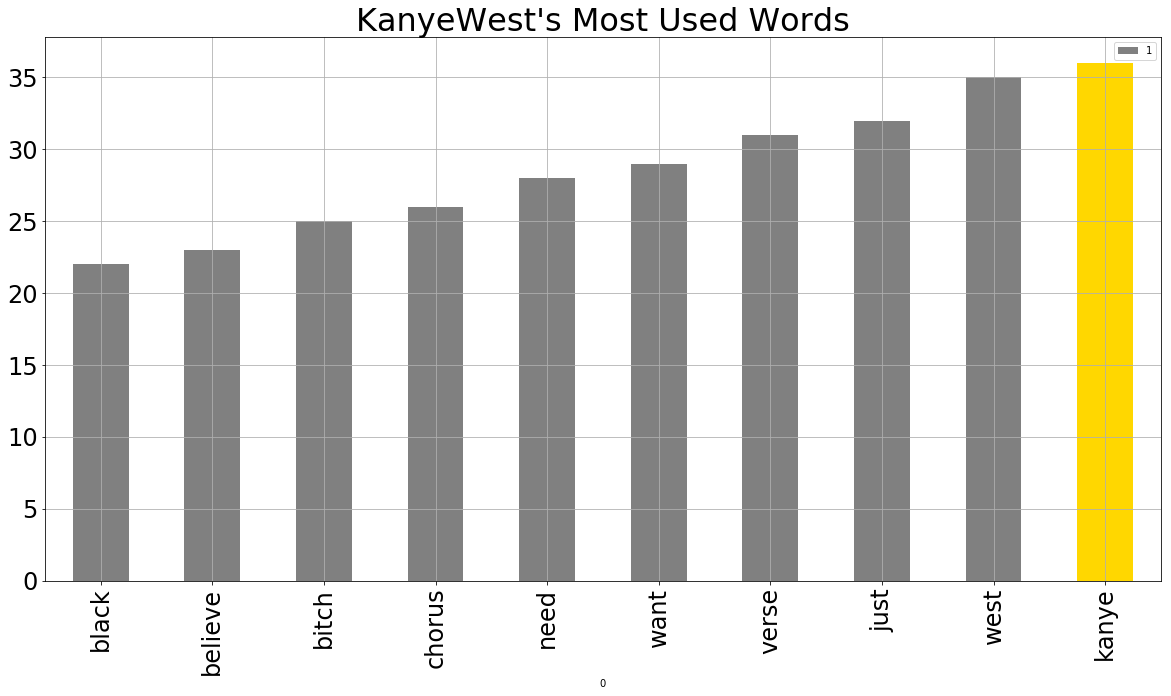

In [14]:
for rapper in data_w_stopwords.columns:
    plot_tuples(rapper)

## WordCloud

In [15]:
# First install the wordcloud library in your terminal because it does not
# come standard. This will show all of the different words the rappers use.

from wordcloud import WordCloud

wc = WordCloud(stopwords=stopwords, 
               background_color='white', # I am going to want to change this to transparent in the future
               max_font_size=150, # need to add the color map
               random_state= 42)

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [16,6]

# We will use the names for the titles
full_names = df_dtm.columns.to_list()

# Create subplots for each rapper
for index, rapper in enumerate (df_dtm.columns):
    # instantiate the wordcloud
    wc.generate(data_clean.Lyrics[rapper])
    
    # instantiate the subplots
    plt.subplot(3, 4, index + 1) # why plus 1
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(full_names[index])

In [ ]:
plt.show()

In [16]:
full_names = df_dtm.columns.to_list()

### Findings

[Analyze the plot and insert findings here]

## Number of Words

In [18]:
# find the number of unique words that each rapper uses

# identify the non-zero items in the dtm
unique_list = []
for rapper in df_dtm.columns:
    uniques = df_dtm[rapper].nonzero()[0].size # Look at words that are actually in each rappers vocab
    unique_list.append(uniques)
#     lexicalDiversity = np.array(unique_list)/len(df_dtm[rapper])

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)),
                          columns = ['rapper', 'unique_words'])
data_unique_sort = data_words.sort_values(by = 'unique_words')
data_unique_sort.reset_index(drop=True)

C:\Users\Vonn\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


,rapper,unique_words
0,Drake,928
1,Future,989
2,Jayz,1257
3,KanyeWest,1412
4,Nas,1859
5,Eminem,2294


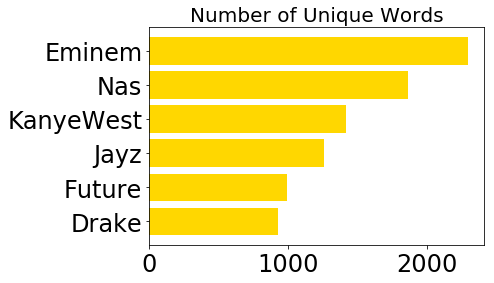

In [31]:
y_pos = np.arange(len(data_words)) # what is this for?

plt.barh(y_pos, data_unique_sort.unique_words, align='center', color = 'gold') # create a h-bar plot
plt.yticks(y_pos, data_unique_sort.rapper)
plt.title("Number of Unique Words", fontsize = 20);

### Findings

- Eminem is clearly the rapper who uses the most unique set of words. 
- Drake is the rapper who has a lexicon that is a little bit lower. But is it because he is rapping about the same things or is he more of a pop artist than a rap artist?

## Profanity

In [ ]:
# Isolating bad words
data_bad_words = df_dtm.transpose()[['fuck',
                                    'fucking',
                                    'fucks','nigga', 
                                    'niggas', 
                                    'shit', 
                                    'bitch',
                                    'bitches',
                                    'pussy',
                                    'hoes',
                                    'muhfucka',
                                    'motherfucker',
                                    'motherfucking',
                                    'ass']]

data_profanity = pd.concat([data_bad_words.fuck\
                          + data_bad_words.fucking\
                          + data_bad_words.fucks\
                          + data_bad_words.bitch\
                          + data_bad_words.shit\
                          + data_bad_words.bitches\
                          + data_bad_words.pussy\
                          + data_bad_words.hoes\
                          + data_bad_words.muhfucka\
                          + data_bad_words.motherfucker\
                          + data_bad_words.ass\
                          + data_bad_words.motherfucking,
                           data_bad_words.nigga\
                           + data_bad_words.niggas], axis= 1)
data_profanity.columns = ['bad_words', 'n_words']
data_profanity

In [ ]:
# Create a scatter plot to visualize the profanity of each rapper
plt.rcParams['figure.figsize'] = [10,8]

for i, rapper in enumerate(data_profanity.index):
    x = data_profanity.bad_words.loc[rapper]
    y = data_profanity.n_words.loc[rapper]
    plt.scatter(x, y, color = 'gold')
    plt.text(x-5.0, y-3.5, full_names[i], fontsize = 10)
#     plt.xlim(-5, 155)
    
plt.title ('Bad Words', fontsize = 20)
plt.xlabel('Number of Bad words sans the N-word', fontsize = 15)
plt.ylabel ('Number of N-Bombs', fontsize = 15);

### Findings

- Drake and Nas are not as profane as other rappers. In fact among the rappers here he drops the least amount of N-bombs and the least amount of curse words. Making him a much more mainstream artist.

## Sentiment Analysis

In [ ]:
# To do this we will first install text blob and import it
from textblob import TextBlob

In [ ]:
# here is a sample of how it works
TextBlob("I love you").sentiment

I never used this before so it's important to understand what is going on first.

- There are two scores you get for each output: polarity and subjectivity. Polarity will tell you if the document is negative or positive based off the words used. Each word has a built in negative or positive score already so this ouput is an amalgamation of the words in the document. The second score is the subjectivity score which will tell you how opinionated the document is.
- Polarity ranges from -1(negative) to 1(positive). Subjectivity ranges from 0(objective) to 1(subjective).
- TextBlob finds all of the words and phrases that it can assign a polarity and subjectivity to, and averages them all together.
- Other ways of doing this is with Naive Bayes.

In [ ]:
# we need to use a corpus for this, not a docuemnt term matrix
data = pd.read_pickle('DataFrame_Corpus.pkl')
data

In [ ]:
# Create quick lambda functions to find the polarity and subjectivity of each corpus
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity']     = data['Lyrics'].apply(pol) # this will apply the sentiment analysis to each index
data['subjectivity'] = data['Lyrics'].apply(sub)
data

In [ ]:
# visualize these scores to make findings easier to discern
plt.rcParams['figure.figsize'] = [10,8] # I just learned that rcParams allows you to create an instance to handle defaults

# we are going to create a scatter plot to understand where a falls in terms of opinionated and sentiment
for index, rapper in enumerate(data.index):
    # create the x variable
    x = data.polarity.loc[rapper]
    # create the y variable
    y = data.subjectivity.loc[rapper]
    # create the scatter plot
    plt.scatter(x,y, color = 'gold')
    # add text to each point
    plt.text(x+.001, y+.001, data['Artist Name'][index], fontsize = 10) # this is why we added a name section in to the corpus
    # set the limit of the plot so it is tighter
#     plt.xlim(-0.01, 0.12)
    
    # we need a title
    plt.title('Sentiment Analysis', fontsize = 20)
    # Label the X axis
    plt.xlabel ('<--Negative --------- Postive -->', fontsize= 15)
    plt.ylabel ('<--Facts ---------- Opinions -->', fontsize = 15)

In [ ]:
# visualize these scores to make findings easier to discern
plt.rcParams['figure.figsize'] = [10,8] # I just learned that rcParams allows you to create an instance to handle defaults
plt.barh(data.index, data.polarity,
        color = 'gold',
         align = 'center');

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
plt.barh(data.index, data.subjectivity,
        color = 'gold',
        align= 'center');

### Findings